In [7]:
using GraphPPL, ReactiveMP, Distributions
using Plots

In [8]:
# Generate toy dataset
T = 15
x_0_data = 0.6
a_data = 1.2

x_data = Vector{Float64}(undef, T)
y_data = Vector{Float64}(undef, T)

x_t_min_data = x_0_data
for t=1:T
    x_data[t] = a_data*x_t_min_data
    y_data[t] = ceil(x_data[t])
    
    x_t_min_data = x_data[t]
end    
;

In [9]:
# Specify forward transition
f(x_t_min, a) = a*x_t_min


@model function NKS(n)
    o = datavar(Float64, n)
    z = randomvar(n)
    a = randomvar(n)

    z_0 ~ Normal(μ=0.0, γ=1.0)
    z_prev = z_0
    for i in 1:n
        a[i] ~ Normal(μ=1.0, γ=2.0)
        z[i] ~ f(z_prev, a[i]) where {meta=ET()}
        o[i] ~ Normal(μ=z[i], σ²=0.2)

        z_prev = z[i]
    end
end

In [10]:
n = length(y_data)
result = inference(model = Model(NKS, n), data=(o=y_data,), free_energy=false)

Inference results:
-----------------------------------------
a   = NormalWeightedMeanPrecision{Float64}[NormalWeightedMeanPrecision{Float64}(xi=2.0...
z_0 = NormalWeightedMeanPrecision{Float64}(xi=7.48395402951275, w=8.003131877629334)
z   = NormalWeightedMeanPrecision{Float64}[NormalWeightedMeanPrecision{Float64}(xi=7.4...


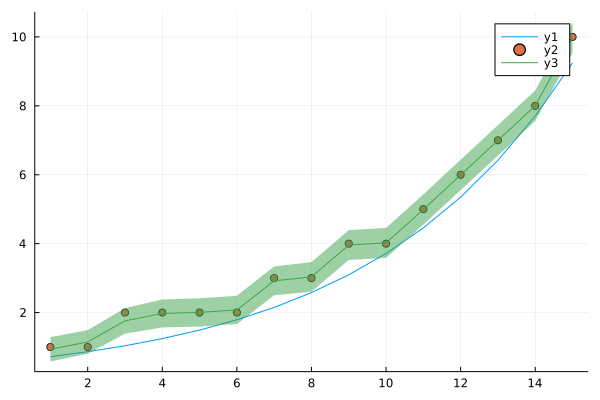

In [11]:

plot(x_data)
scatter!(y_data)
plot!(mean.(result.posteriors[:z]), ribbon=sqrt.(var.(result.posteriors[:z])))

In [12]:
m_a, v_a = mean.(result.posteriors[:a]), var.(result.posteriors[:a]);
m_x, v_x = mean.(result.posteriors[:z]), var.(result.posteriors[:z])

([0.9351281653164045, 1.1472007319478026, 1.7591708481837578, 1.9745316776239774, 2.0042463282219414, 2.0771029437023, 2.92099385615434, 3.035792724047629, 3.960396089499047, 4.022655679980277, 4.991958108687877, 5.994990967792215, 6.997053779835974, 8.004174031571754, 9.987578434371425], [0.1249510835620788, 0.11730115784596662, 0.1377037914819956, 0.16467503101747194, 0.16862860301622637, 0.1690454118548288, 0.17595774882108517, 0.18385849711929958, 0.18733044187432812, 0.19059892892075275, 0.19224920712865384, 0.19475119976389124, 0.19623766672330814, 0.19717114631087887, 0.19876288310588452])

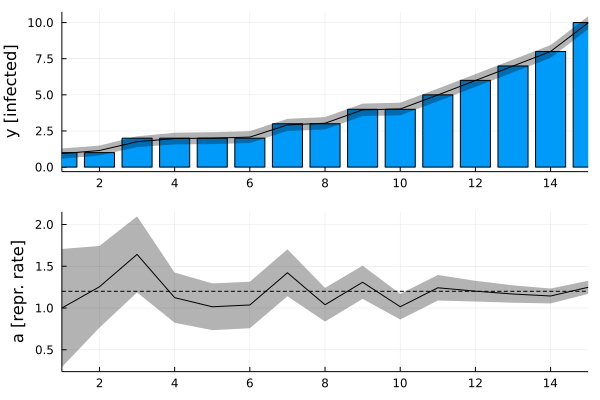

In [13]:
p1 = bar(1:T, y_data, label=false)
plot!(1:T, m_x, color=:black, ribbon=sqrt.(v_x), fillalpha=0.3, xlim=(1,T), ylabel="y [infected]", label=false)
p2 = plot(1:T, m_a, color=:black, ribbon=sqrt.(v_a), fillalpha=0.3, xlim=(1,T), ylabel="a [repr. rate]", label=false)
plot!(1:T, a_data*ones(T), color=:black, linestyle=:dash, label=false)
# p3 = plot(1:T, F, color=:black, xlim=(1,T), xlabel="t [days]", ylabel="F [free energy]", label=false)

l = @layout [a; b]
plot(p1, p2, layout = l)

### ET

In [14]:
function f(x)
    return sqrt.(x)
end

function f_inv(x)
    return x .^ 2
end


@model function NKS()
    y2 = datavar(Float64)
    c = zeros(2); c[1] = 1.0;

    x ~ MvNormal(μ=ones(2), Λ=diageye(2))
    z ~ f(x) where {meta=ET(inverse=f_inv)}
    y1 ~ Normal(μ=dot(z, c), σ²=1.0)
    y2 ~ Normal(μ=y1, σ²=0.5)
end

In [15]:
imarginals = (x = MvNormal(zeros(2), diageye(2)), )


result = inference(model = Model(NKS), data=(y2=4.0,), free_energy=false)

Inference results:
-----------------------------------------
y1 = NormalWeightedMeanPrecision{Float64}(xi=8.8, w=2.8)
x  = MvNormalWeightedMeanPrecision(
xi: [1.1666666666669165, 1.0]
Λ: [1.0104166666667...


In [16]:
mean(result.posteriors[:x])

2-element Vector{Float64}:
 1.1546391752579255
 0.4999999999999999

In [17]:
function f(x)
    return sqrt.(x)
end


@model function NKS()
    y2 = datavar(Float64)
    c = zeros(2); c[1] = 1.0;

    x ~ MvNormal(μ=ones(2), Λ=diageye(2))
    z ~ f(x) where {meta=ET()}
    y1 ~ Normal(μ=dot(z, c), σ²=1.0)
    y2 ~ Normal(μ=y1, σ²=0.5)
end

In [18]:
imarginals = (x = MvNormal(zeros(2), diageye(2)), )

result = inference(model = Model(NKS), data=(y2=1.0,), free_energy=false)

Inference results:
-----------------------------------------
y1 = NormalWeightedMeanPrecision{Float64}(xi=2.8, w=2.8)
x  = MvNormalWeightedMeanPrecision(
xi: [1.1666666666664167, 0.99999999999975]
Λ: [1....


In [19]:
mean(result.posteriors[:x])

2-element Vector{Float64}:
 0.9999999999995713
 0.9999999999995

In [20]:
function f(x, θ)
    return x .+ θ
end

function f_x(θ, z)
    return z .- θ
end

function f_θ(x, z)
    return z .- x
end

c = randn(2);

@model function NKS()
    y2 = datavar(Float64)
    c = zeros(2); c[1] = 1.0;

    θ ~ MvNormal(μ=ones(2), Λ=diageye(2))
    x ~ MvNormal(μ=zeros(2), Λ=diageye(2))
    z ~ f(x, θ) where {meta=ET(inverse=(f_x, f_θ))}
    y1 ~ Normal(μ=dot(z, c), σ²=1.0)
    y2 ~ Normal(μ=y1, σ²=0.5)
end

In [21]:
imarginals = (x = MvNormal(zeros(2), diageye(2)), )

result = inference(model = Model(NKS), data=(y2=1.0,), free_energy=false)

Inference results:
-----------------------------------------
y1 = NormalWeightedMeanPrecision{Float64}(xi=2.3333333333333335, w=2.3333333333333335...
θ  = MvNormalWeightedMeanPrecision(
xi: [0.60000000000024, 1.0]
Λ: [1.40000000000036 ...
x  = MvNormalWeightedMeanPrecision(
xi: [5.999645225079745e-13, 9.99999999999e-13]
Λ:...


In [22]:
function f(x, θ, ζ)
    return x .+ θ .+ ζ
end


@model function NKS()
    y2 = datavar(Float64)
    c = zeros(2); c[1] = 1.0;

    θ ~ MvNormal(μ=ones(2), Λ=diageye(2))
    ζ ~ MvNormal(μ=0.5ones(2), Λ=diageye(2))
    x ~ MvNormal(μ=zeros(2), Λ=diageye(2))
    z ~ f(x, θ, ζ) where {meta=ET()}
    y1 ~ Normal(μ=dot(z, c), σ²=1.0)
    y2 ~ Normal(μ=y1, σ²=0.5)
end

In [23]:
imarginals = (x = MvNormal(zeros(2), diageye(2)), )

result = inference(model = Model(NKS), data=(y2=1.0,), free_energy=false)

Inference results:
-----------------------------------------
y1 = NormalWeightedMeanPrecision{Float64}(xi=2.375, w=2.25)
ζ  = MvNormalWeightedMeanPrecision(
xi: [0.4999999999995714, 0.49999999999900013]
Λ: ...
θ  = MvNormalWeightedMeanPrecision(
xi: [1.1428571428568057, 0.9999999999995002]
Λ: [...
x  = MvNormalWeightedMeanPrecision(
xi: [-0.14285714285766313, -1.499911306270087e-12...


In [24]:
function f(x, θ)
    return θ.*x
end

c = randn(2);

@model function NKS()
    y2 = datavar(Float64)
    c = zeros(2); c[1] = 1.0;

    θ ~ Normal(μ=0.5, γ=1.0)
    x ~ MvNormal(μ=zeros(2), Λ=diageye(2))
    z ~ f(x, θ) where {meta=ET()}
    y1 ~ Normal(μ=dot(z, c), σ²=1.0)
    y2 ~ Normal(μ=y1, σ²=0.5)
end

In [25]:
imarginals = (x = MvNormal(zeros(2), diageye(2)), )

result = inference(model = Model(NKS), data=(y2=1.0,), free_energy=false)

Inference results:
-----------------------------------------
y1 = NormalWeightedMeanPrecision{Float64}(xi=2.0, w=2.8)
θ  = NormalWeightedMeanPrecision{Float64}(xi=0.0, w=1.00000000000025)
x  = MvNormalWeightedMeanPrecision(
xi: [0.3333333333333333, 0.0]
Λ: [1.1666666666669...


### UT

In [26]:
function f(x)
    return x
end

function f_inv(x)
    return x
end

c = randn(2);

@model function NKS()
    y2 = datavar(Float64)
    c = zeros(2); c[1] = 1.0;

    x ~ MvNormal(μ=zeros(2), Λ=diageye(2))
    z ~ f(x) where {meta=UT(inverse=f_inv)}
    y1 ~ Normal(μ=dot(z, c), σ²=1.0)
    y2 ~ Normal(μ=y1, σ²=0.5)
end

In [27]:
imarginals = (x = MvNormal(zeros(2), diageye(2)), )

result = inference(model = Model(NKS), data=(y2=1.0,), free_energy=false)

Inference results:
-----------------------------------------
y1 = NormalWeightedMeanPrecision{Float64}(xi=2.0, w=2.5)
x  = MvNormalWeightedMeanPrecision(
xi: [0.6666666666676693, 0.0]
Λ: [1.6666666666676...


In [28]:
function f(x)
    return x.^2
end

c = randn(2);

@model function NKS()
    y2 = datavar(Float64)
    c = zeros(2); c[1] = 1.0;

    x ~ MvNormal(μ=zeros(2), Λ=diageye(2))
    z ~ f(x) where {meta=UT()}
    y1 ~ Normal(μ=dot(z, c), σ²=1.0)
    y2 ~ Normal(μ=y1, σ²=0.5)
end

In [29]:
imarginals = (x = MvNormal(zeros(2), diageye(2)), )

result = inference(model = Model(NKS), data=(y2=1.0,), free_energy=false)

(μ_fw_in, Σ_fw_in) = ([[0.0, 0.0]], [[1.0 -0.0; -0.0 1.0]])


LoadError: DimensionMismatch: dimensions must match: a has dims (Base.OneTo(2), Base.OneTo(2)), b has dims (Base.OneTo(1),), mismatch at 1

In [26]:
function f(x, θ)
    return x .+ θ
end

function f_x(θ, z)
    return z .- θ
end

function f_θ(x, z)
    return z .- x
end

c = randn(2);

@model function NKS()
    y2 = datavar(Float64)
    c = zeros(2); c[1] = 1.0;

    θ ~ MvNormal(μ=ones(2), Λ=diageye(2))
    x ~ MvNormal(μ=zeros(2), Λ=diageye(2))
    z ~ f(x, θ) where {meta=UT(inverse=(f_x, f_θ))}
    y1 ~ Normal(μ=dot(z, c), σ²=1.0)
    y2 ~ Normal(μ=y1, σ²=0.5)
end

In [29]:
imarginals = (x = MvNormal(zeros(2), diageye(2)), )

result = inference(model = Model(NKS), data=(y2=1.0,), free_energy=false)

Inference results:
-----------------------------------------
y1 = NormalWeightedMeanPrecision{Float64}(xi=2.333333333352748, w=2.3333333333333455)...
θ  = MvNormalWeightedMeanPrecision(
xi: [0.5999999999880001, 1.0]
Λ: [1.4000000000003...
x  = MvNormalWeightedMeanPrecision(
xi: [-1.0511773545936107e-11, 1.0000000167191506e...


In [30]:
function f(x, θ)
    return θ.*x
end

c = randn(2);

@model function NKS()
    y2 = datavar(Float64)
    c = zeros(2); c[1] = 1.0;

    θ ~ Normal(μ=0.5, γ=2.0)
    x ~ MvNormal(μ=zeros(2), Λ=diageye(2))
    z ~ f(x, θ) where {meta=UT()}
    y1 ~ Normal(μ=dot(z, c), σ²=1.0)
    y2 ~ Normal(μ=y1, σ²=0.5)
end

In [31]:
imarginals = (x = MvNormal(zeros(2), diageye(2)), )

result = inference(model = Model(NKS), data=(y2=1.0,), free_energy=false)

Inference results:
-----------------------------------------
y1 = NormalWeightedMeanPrecision{Float64}(xi=2.0, w=2.8)
θ  = NormalWeightedMeanPrecision{Float64}(xi=0.0, w=1.00000000000025)
x  = MvNormalWeightedMeanPrecision(
xi: [0.3333333333333333, 0.0]
Λ: [1.1666666666669...
